In [14]:
!mkdir GloVe
!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip GloVe/glove.840B.300d.zip -d GloVe/
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [3]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  22.0M      0  0:00:06  0:00:06 --:--:-- 26.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  17.5M      0  0:00:08  0:00:08 --:--:-- 25.5M


In [1]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
from InferSent.models import InferSent
import torch
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

In [7]:
W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent.set_w2v_path(W2V_PATH)

# read file

In [8]:
def read_txt(path):
    with open(path, 'r', encoding="utf-8") as f:
        text = f.readlines()
#         text = [x.decode("utf-8") for x in f.readlines()]
    return text

text = read_txt('./data/apple.txt')
# text = [x.decode("utf-8") for x in text]

In [9]:
text

['\n',
 'A. INTRODUCTION TO OUR SERVICES\n',
 'This Agreement governs your use of Apple’s services (“Services”), through which you can buy, get, license, rent or subscribe to content, apps (“Apps”), and other in-app services (collectively, “Content”). Content may be offered through the Services by Apple or a third party. Our Services are available for your use in your country of residence (“Home Country”). To use our Services, you need compatible hardware, software (latest version recommended and sometimes required) and Internet access (fees may apply). Our Services’ performance may be affected by these factors.\n',
 '\n',
 'B. USING OUR SERVICES\n',
 'PAYMENTS, TAXES, AND REFUNDS\n',
 'You can acquire Content on our Services for free or for a charge, either of which is referred to as a “Transaction.” Each Transaction is an electronic contract between you and Apple, and/or you and the entity providing the Content on our Services. However, if you are a customer of Apple Distribution Int

In [10]:
condition_terms = []
stringg=''
for tex in text[1:]:
    if tex=='\n':
        condition_terms.append(stringg)
        stringg=''
    else: stringg+=tex
condition_terms=[x.replace('\n', ' ') for x in condition_terms]

In [11]:
print(len(condition_terms))
condition_terms

31


['A. INTRODUCTION TO OUR SERVICES This Agreement governs your use of Apple’s services (“Services”), through which you can buy, get, license, rent or subscribe to content, apps (“Apps”), and other in-app services (collectively, “Content”). Content may be offered through the Services by Apple or a third party. Our Services are available for your use in your country of residence (“Home Country”). To use our Services, you need compatible hardware, software (latest version recommended and sometimes required) and Internet access (fees may apply). Our Services’ performance may be affected by these factors. ',
 'B. USING OUR SERVICES PAYMENTS, TAXES, AND REFUNDS You can acquire Content on our Services for free or for a charge, either of which is referred to as a “Transaction.” Each Transaction is an electronic contract between you and Apple, and/or you and the entity providing the Content on our Services. However, if you are a customer of Apple Distribution International and you acquire an App

In [12]:
infersent.build_vocab(condition_terms, tokenize=True)

Found 1456(/1492) words with w2v vectors
Vocab size : 1456


In [14]:
embeddings = infersent.encode(condition_terms, tokenize=True)

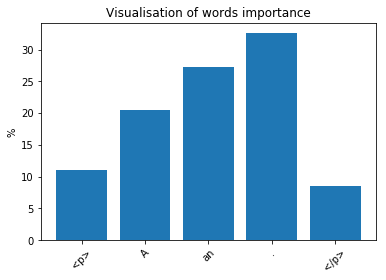

In [20]:
a= infersent.visualize('A man plays an instrument.', tokenize=True)

In [24]:
a[0] 

tensor([[ 0.0075, -0.1063, -0.0085,  ..., -0.0690,  0.0029, -0.0139]],
       grad_fn=<MaxBackward0>)